In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import torch
import warnings

from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d
from sklearn.datasets import make_blobs, make_regression
from tqdm import tqdm
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import normalize, standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.exceptions.warnings import InputDataWarning
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings(
    "ignore",
    message="Input data is not standardized.",
    category=InputDataWarning,
)
warnings.filterwarnings("ignore")

random.seed(42)

### timing plots

Text(0.5, 1.0, 'y')

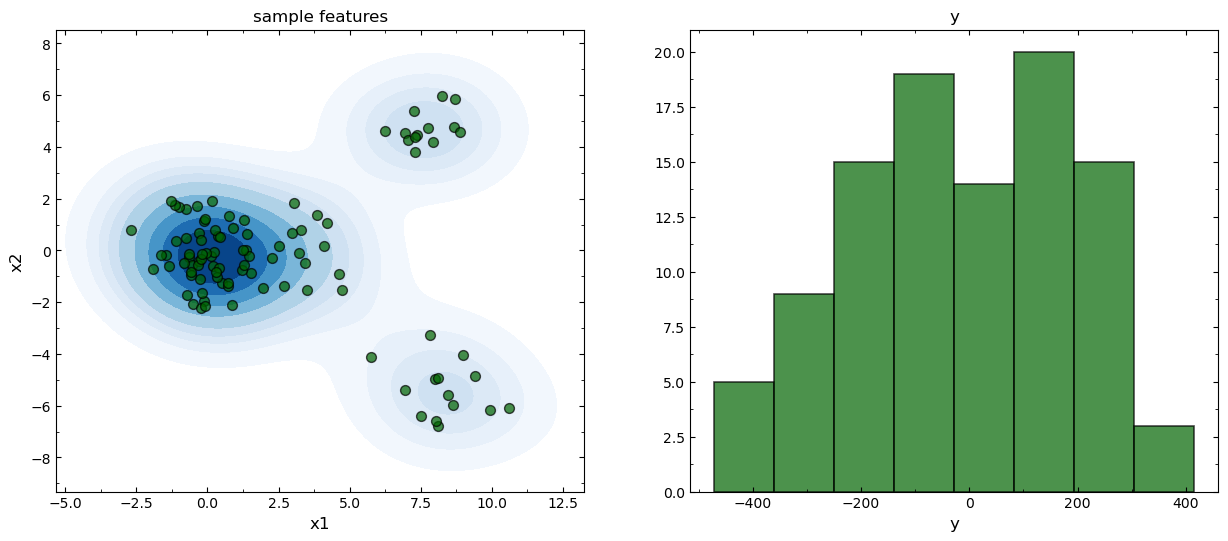

In [ ]:
x1, y1 = make_regression(n_samples=60, n_features=2, noise=200, random_state=150)
xblob, yblob = make_blobs(n_samples=40, centers=3, n_features=2, random_state=150, cluster_std=0.9)

samples = np.random.normal(y1.mean(), y1.std(), 40)

x1 = np.concatenate((x1, xblob), axis=0)
y1 = np.concatenate((y1, samples), axis=0)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15, 6))

x1_min, x1_max = x1[:,0].min(), x1[:,0].max()
x2_min, x2_max = x1[:,1].min(), x1[:,1].max()

padding_factor = 0.2  
x1_range = x1_max - x1_min
x2_range = x2_max - x2_min

ax1.set_xlim(x1_min - padding_factor * x1_range, x1_max + padding_factor * x1_range)
ax1.set_ylim(x2_min - padding_factor * x2_range, x2_max + padding_factor * x2_range)

sns.kdeplot(x=x1[:,0], y=x1[:,1], cmap='Blues', fill=True, ax=ax1)

ax1.scatter(x1[:,0], x1[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1.0,alpha=0.7)
ax1.set_xlabel("x1", size=12)
ax1.set_ylabel("x2", size=12)
# ax.set_xlim([-7, 7])
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
# ax.set_xticks(np.arange(0, 7, 25))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.set_title("sample features", size=12)
# ax1.legend()



# y_max_hist = max(abs(y1.min()), abs(y1.max()))
# ax2.set_xlim(-10 + -y_max_hist, 10 + y_max_hist)
ax2.hist(y1, bins='auto', color="darkgreen", edgecolor='black', linewidth=1.2, alpha=0.7)
ax2.set_xlabel("y", size=12)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.set_title("y", size=12)
# ax2.legend()



In [ ]:
xlower_bounds = x1.min(axis=0)
xupper_bounds = x1.max(axis=0)

xlower_bounds = torch.tensor(xlower_bounds, dtype=torch.double)
xupper_bounds = torch.tensor(xupper_bounds, dtype=torch.double)

xbounds = torch.stack([xlower_bounds, xupper_bounds])
xbounds

#convert array to tensor
x = torch.tensor(x1, dtype=torch.double)
y = torch.tensor(y1, dtype=torch.double)

x = normalize(x, bounds=xbounds)  
y = standardize(y)

In [96]:
x_candidates, x_test, y_candidates, y_test = train_test_split(x, y, test_size=0.30, random_state=300)

xtest = torch.tensor(x_test, dtype=torch.double)
ytest = torch.tensor(y_test, dtype=torch.double)

xcandidates_original = torch.tensor(x_candidates, dtype=torch.double)
ycandidates_original = torch.tensor(y_candidates, dtype=torch.double)

In [97]:
bnds = torch.tensor([[0,0], [1,1]], dtype=torch.double)
bounds = torch.tensor(bnds, dtype=torch.double)
bounds

tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)

In [98]:
from botorch.utils.sampling import draw_sobol_samples

mcp = draw_sobol_samples(bounds=bounds, n=1024, q=1, seed=300).squeeze(1)
mcp.shape

torch.Size([1024, 2])

In [99]:
def random_initial_data(x, y, initial_percent, seed):
    np.random.seed(seed)
    n = int(x.shape[0]*initial_percent)
    idx = np.random.choice(x.shape[0], n, replace=False)
    x_initial = x[idx]
    y_initial = y[idx]
    x_candidates = np.delete(x, idx, axis=0)
    y_candidates = np.delete(y, idx, axis=0)
    return x_initial, y_initial, x_candidates, y_candidates

In [81]:
xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

In [100]:
ycandidates = ycandidates.unsqueeze(-1)
ycandidates.shape

torch.Size([70, 1])

In [ ]:
gp = SingleTaskGP(xcandidates, ycandidates) 
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()

ymae = mean_absolute_error(ytest, ypred_mean)
ymae

0.7631796400379124

In [102]:
rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []
qnipv_runs =[]
candidates_selected =[]
qnipv_vals = []
candidates_qnpiv = []

list_of_acq_vals = []
def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())
        
        # print(qNIVP_val)
        # all_qnivp_vals.append(qNIVP_val)
        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst, 


seeds = [300]

for i in tqdm(seeds):
    xcandidates = xcandidates_original.clone()
    ycandidates = ycandidates_original.clone()
    xinit, yinit, xcandidates, ycandidates = random_initial_data(xcandidates, ycandidates, 0.05, seed=i)
    yinit = yinit.unsqueeze(-1)
    ycandidates = ycandidates.unsqueeze(-1)
    
    gp = SingleTaskGP(xinit, yinit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    ystd = posterior.stddev.detach().numpy()
    
    ymae = mean_absolute_error(ytest, ypred)
    
    pred_mae = []
    pred_y.append(ypred)
    pred_std.append(ystd)
    pred_mae.append(ymae)

    for inner_i in tqdm(range(len(xcandidates))):
        if not len(xcandidates):
            break
        
        qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
        
        
        max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
        
        list_of_acq_vals.append(acq_val_lst)
        
        candidates_qnpiv.append(xcandidates)
        xmax_candidates.append(max_index)
        
        xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
        yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
        
        xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
        ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
        
        
        gp = SingleTaskGP(xinit, yinit) 
        # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        #predict the y values for the test set
        ypred = gp(xtest)
        ypred_mean = ypred.mean.detach().numpy()
        pred_y.append(ypred_mean)

        #calculate the mean absolute error and the standard deviation for the test set
        ymae = mean_absolute_error(ytest, ypred_mean)
        # print('mean absolute error: ', ymae)
        pred_mae.append(ymae)
        ystd = gp(xtest).stddev
        ystd = ystd.detach().numpy()
        pred_std.append(ystd)
    
    
    qnipv_vals
    candidates_qnpiv
    list_of_acq_vals
    xinit
    qnipv_runs.append(pred_mae)

100%|██████████| 1/1 [00:24<00:00, 24.55s/it]


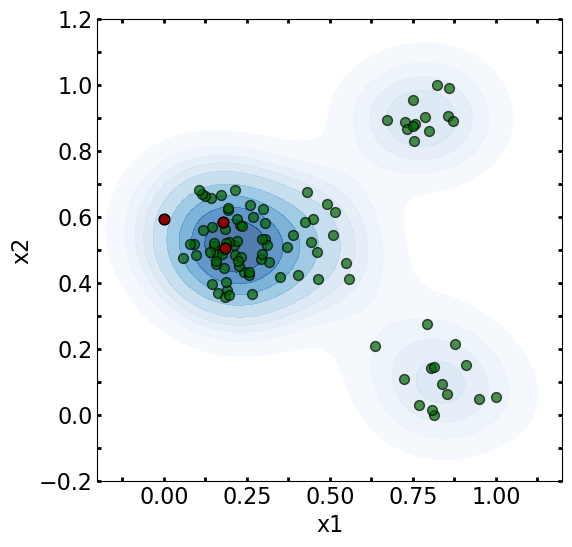

In [ ]:
fig, (ax) = plt.subplots(nrows=1 ,figsize=(6, 6))

x_min, x_max = x[:,0].min(), x[:,0].max()
x2_min, x2_max = x[:,1].min(), x[:,1].max()

padding_factor = 0.2  
x_range = x_max - x_min
x2_range = x2_max - x2_min

ax.set_xlim(x_min - padding_factor * x_range, x_max + padding_factor * x_range)
ax.set_ylim(x2_min - padding_factor * x2_range, x2_max + padding_factor * x2_range)

sns.kdeplot(x=x[:,0], y=x[:,1], cmap='Blues', fill=True, ax=ax, legend=True,alpha=0.7)


ax.tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
ax.scatter(x[:,0], x[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1.0,alpha=0.7)
ax.scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1, label='Initialization Set')
ax.set_xlabel("x1", size=16)
ax.set_ylabel("x2", size=16)
# ax.set_xlim([-7, 7])
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
# ax.set_xticks(np.arange(0, 7, 25))
ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

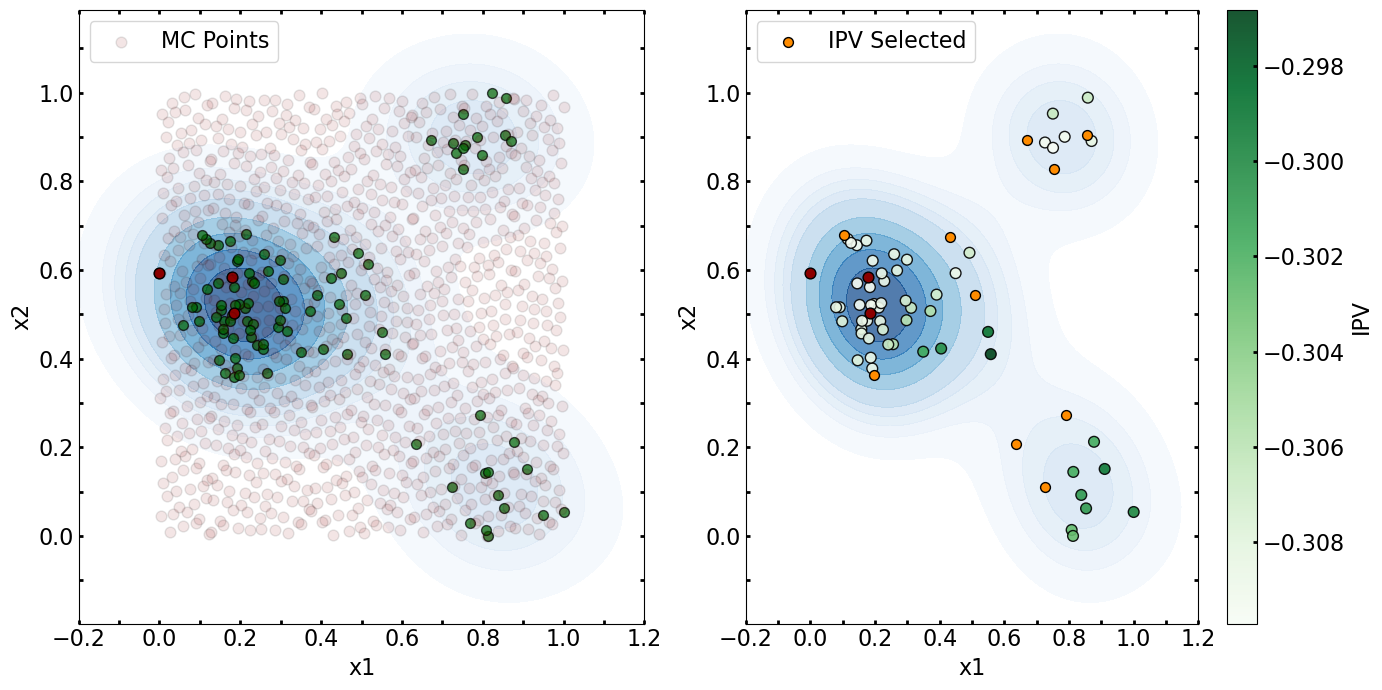

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),sharex=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
ax[0].scatter(x[:,0], x[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1.0,alpha=0.7)
ax[0].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1)
ax[0].scatter(mcp[:,0], mcp[:,1], c='darkred', s=60, edgecolor='k', linewidth=1,alpha=0.1, label='MC Points')


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
cb = ax[1].scatter(candidates_qnpiv[10][:,0], candidates_qnpiv[10][:,1], c=list_of_acq_vals[10], cmap="Greens",s=60, edgecolor='k', linewidth=1,alpha=0.9)
cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("IPV", size=16)
cbar.ax.tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
ax[1].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1)

ax[1].scatter(xinit[3:13,0], xinit[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='IPV Selected')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)


for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()
    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2
    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=16)
    ax[i].set_ylabel("x2", size=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left',fontsize=16)

plt.tight_layout()
# fig.savefig("figure_init2.pdf", bbox_inches="tight")
plt.show()

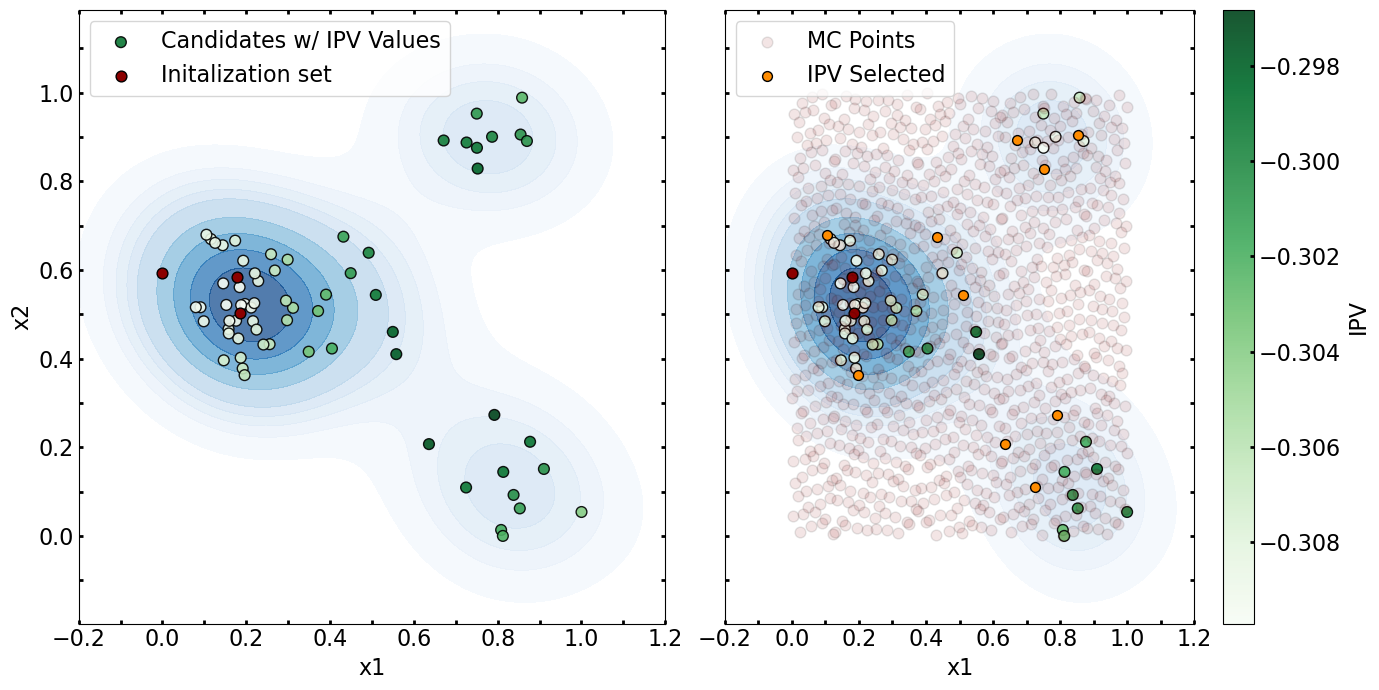

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),sharex=True,sharey=True)


xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
ax[0].scatter(candidates_qnpiv[0][:,0], candidates_qnpiv[0][:,1],
c=list_of_acq_vals[0], cmap="Greens",s=60, edgecolor='k', linewidth=1,
label='Candidates w/ IPV Values',alpha=0.9)
ax[0].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1, label='Initalization set')


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
cb = ax[1].scatter(candidates_qnpiv[10][:,0], candidates_qnpiv[10][:,1], c=list_of_acq_vals[10], cmap="Greens",s=60, edgecolor='k', linewidth=1,alpha=0.9)
cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("IPV", size=16)
# cbar.ax.tick_params(labelsize=16)
cbar.ax.tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
ax[1].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1)
ax[1].scatter(mcp[:,0], mcp[:,1], c='darkred', s=60, edgecolor='k', linewidth=1,alpha=0.1, label='MC Points')
ax[1].scatter(xinit[3:13,0], xinit[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='IPV Selected')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
# ax[1].set_title("First 10 IPV Selected Candidates", size=16)

for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()
    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2
    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=16)
    ax[i].set_ylabel("x2", size=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left',fontsize=16)

plt.tight_layout()
# fig.savefig("figure_7.pdf", bbox_inches="tight")
plt.show()

In [ ]:

xcandidates_rand = xcandidates_original.clone()
ycandidates_rand = ycandidates_original.clone()

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []


random_mae_seeds =[]

seeds = [300]
for i in tqdm(seeds):
    xcandidates_rand = xcandidates_original.clone()
    ycandidates_rand = ycandidates_original.clone()
    xinit_rand, yinit_rand, xcandidates_rand, ycandidates_rand = random_initial_data(xcandidates_rand, ycandidates_rand, 0.05, seed=i)
    yinit_rand = yinit_rand.unsqueeze(-1)
    ycandidates_rand = ycandidates_rand.unsqueeze(-1)
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    rand_pred_mae.append(rand_ymae)
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    
    
    
    for inner_i in tqdm(range(len(xcandidates_rand))):
        if not len(xcandidates_rand):
            break
        
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
    
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


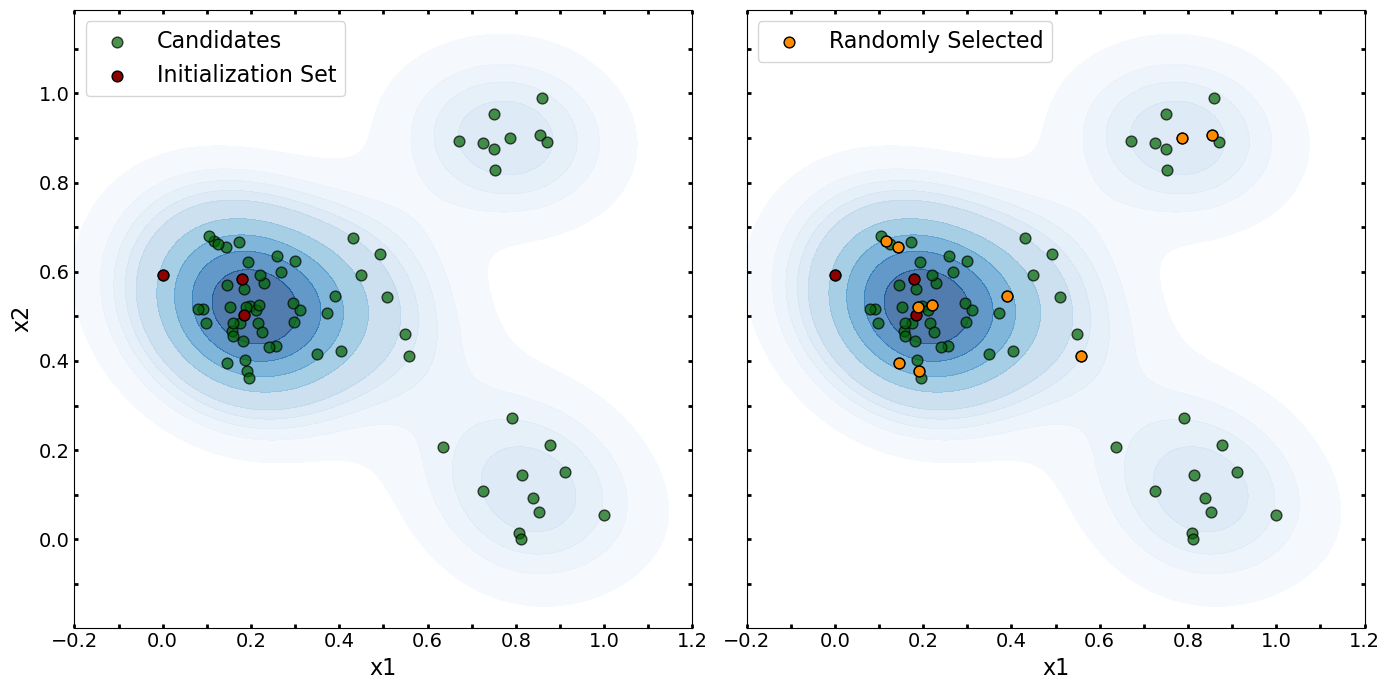

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True, alpha=0.7)
ax[0].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=60, edgecolor='k', linewidth=1, label='Candidates',alpha=0.7)
ax[0].scatter(xinit_rand[:3,0], xinit_rand[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1, label='Initialization Set')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
ax[1].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=60, edgecolor='k', linewidth=1,alpha=0.7)
ax[1].scatter(xinit_rand[:3,0], xinit_rand[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1)
ax[1].scatter(xinit_rand[3:13,0], xinit_rand[3:13,1], c='darkorange', s=60, edgecolor='k', linewidth=1, label='Randomly Selected')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)


for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=16)
    ax[i].set_ylabel("x2", size=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=14)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left',fontsize=16)

plt.tight_layout()
# fig.savefig("figure_4.pdf", bbox_inches="tight")
plt.show()

In [ ]:
selected_disagreements = []
max_disagreements = []

gp_commit_lst = []
candidate_disagreements = []    

committee = [
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

comit_pred_mae = []

commit_seeds = []
disagreement_scores_list = []
for i in tqdm(seeds):
    
    xcandidates_comit = xcandidates_original.clone()
    ycandidates_comit = ycandidates_original.clone()
    xinit_comit, yinit_comit, xcandidates_comit, ycandidates_comit = random_initial_data(xcandidates_comit, ycandidates_comit, 0.05, seed=i)
    gp_commit_lst = []
    
    yinit_comit = yinit_comit.unsqueeze(-1)
    ycandidates_comit = ycandidates_comit.unsqueeze(-1)
    
    gp = SingleTaskGP(xinit_comit, yinit_comit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    
    # gp_commit_lst.append(ypred)
    comitt_ymae = mean_absolute_error(ytest, ypred)
    gp_commit_lst.append(comitt_ymae)
    for inner_i in tqdm(range(len(xcandidates_comit))):
        if not len(xcandidates_comit):
            print('empty')
            break
       
        for model in committee:
            model.fit(xinit_comit, yinit_comit)

        predictions = np.array([model.predict(xcandidates_comit) for model in committee])
        
        disagreement_scores = np.var(predictions, axis=0)
        max_disagreements.append(np.max(disagreement_scores))

        N = 1  
        top_N_indices = np.argsort(disagreement_scores)[-N:]
        selected_disagreements.append(disagreement_scores[top_N_indices][0])

        disagreement_scores_list.append(disagreement_scores)
        candidate_disagreements.append(xcandidates_comit)
        X_to_query = xcandidates_comit[top_N_indices]
        
        ylabel = ycandidates_comit[top_N_indices]
        
        xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
        yinit_comit = torch.cat((yinit_comit, ylabel), 0)
        
        xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
        ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
        
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
            
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
    candidate_disagreements
    disagreement_scores_list
    commit_seeds.append(gp_commit_lst)

100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


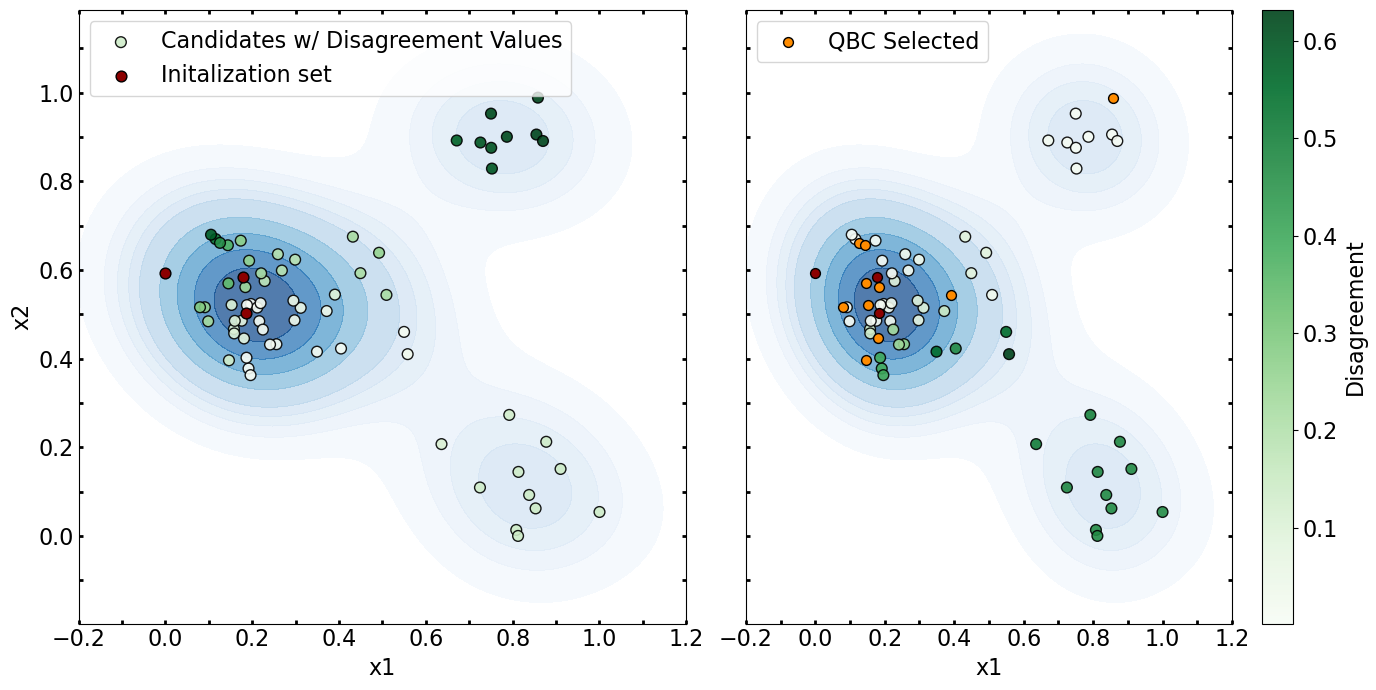

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)
ax[0].scatter(candidate_disagreements[0][:,0], candidate_disagreements[0][:,1], c=disagreement_scores_list[0], cmap="Greens",s=60, edgecolor='k', linewidth=1, label='Candidates w/ Disagreement Values',alpha=0.9)
ax[0].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1, label='Initalization set')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
# ax[0].set_title("Initial Candidate Space With Disagreement Values", size=16)



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
cb = ax[1].scatter(candidate_disagreements[10][:,0], candidate_disagreements[10][:,1], c=disagreement_scores_list[10], cmap="Greens",s=60, edgecolor='k', linewidth=1,alpha=0.9)
cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("Disagreement", size=16)
cbar.ax.tick_params(labelsize=16)


ax[1].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1)

ax[1].scatter(xinit_comit[3:13,0], xinit_comit[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='QBC Selected')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
# ax[1].scatter(xinit_comit[3:9,0], xinit_comit[3:9,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='QBC Selected')
# ax[1].set_title("First 10 Selected QBC Candidates", size=16)



for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=16)
    ax[i].set_ylabel("x2", size=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=14)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left',fontsize=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)

plt.tight_layout()
# fig.savefig("figure_6.pdf", bbox_inches="tight")
plt.show()

In [ ]:
uncr_xmax_candidates = []
uncr_pred_mae = []
uncr_pred_std = []
uncr_pred_mean = []
unc_rand_mae_seeds = []
uncr_pred_candidates = []
uncr_candidates = []

for i in seeds:    
    
    xcandidates_uncr = xcandidates_original.clone()
    ycandidates_uncr = ycandidates_original.clone()
    xinit_uncr, yinit_uncr, xcandidates_uncr, ycandidates_uncr = random_initial_data(xcandidates_uncr, ycandidates_uncr, 0.05, seed=i)
    
    yinit_uncr = yinit_uncr.unsqueeze(-1)
    ycandidates_uncr = ycandidates_uncr.unsqueeze(-1)
    
    uncr_xmax_candidates = []
    uncr_pred_mae = []
    uncr_pred_std = []
    uncr_pred_mean = []

    # Train the initial GP model on the initial training set
    gp = SingleTaskGP(xinit_uncr, yinit_uncr)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Predict on the test set initially
    uncr_ypred = gp(xtest)
    uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
    uncr_pred_mean.append(uncr_ypred_mean)
    
    # Calculate the initial mean absolute error (MAE) for the test set
    uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
    # print('Initial mean absolute error: ', uncr_ymae)
    uncr_pred_mae.append(uncr_ymae)
    
    # Calculate and store the initial standard deviation for the test set predictions
    uncr_ystd = gp(xtest).stddev.detach().numpy()
    uncr_pred_std.append(uncr_ystd)
    # print("Initial length of xinit", len(xinit_uncr))

    # Active learning loop (25 iterations)
    for inner_i in tqdm(range(len(xcandidates_uncr))):
        if not len(xcandidates_uncr):
            print('empty')
            break
        # Predict the uncertainty (posterior stddev) for all candidate points
        posterior_candidates = gp(xcandidates_uncr)
        uncertainties = posterior_candidates.stddev.detach().numpy() 
        uncr_pred_candidates.append(uncertainties)
        uncr_candidates.append(xcandidates_uncr)

        max_uncertainty_idx = uncertainties.argmax()

        xinit_uncr = torch.cat((xinit_uncr, xcandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
        yinit_uncr = torch.cat((yinit_uncr, ycandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
        
        # Remove the selected candidate from the candidate set
        xcandidates_uncr = torch.cat((xcandidates_uncr[:max_uncertainty_idx], xcandidates_uncr[max_uncertainty_idx + 1:]))
        ycandidates_uncr = torch.cat((ycandidates_uncr[:max_uncertainty_idx], ycandidates_uncr[max_uncertainty_idx + 1:]))

        # Retrain the GP model on the updated training set
        gp = SingleTaskGP(xinit_uncr, yinit_uncr)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Predict the y values for the test set
        uncr_ypred = gp(xtest)
        uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
        uncr_pred_mean.append(uncr_ypred_mean)

        # Calculate the mean absolute error (MAE) for the test set
        uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
        # print(f'Iteration {i}: mean absolute error = {uncr_ymae}')
        uncr_pred_mae.append(uncr_ymae)

        uncr_ystd = gp(xtest).stddev.detach().numpy()
        uncr_pred_std.append(uncr_ystd)
    uncr_pred_candidates
    uncr_candidates
    unc_rand_mae_seeds.append(uncr_pred_mae)
   

100%|██████████| 67/67 [00:01<00:00, 34.58it/s]


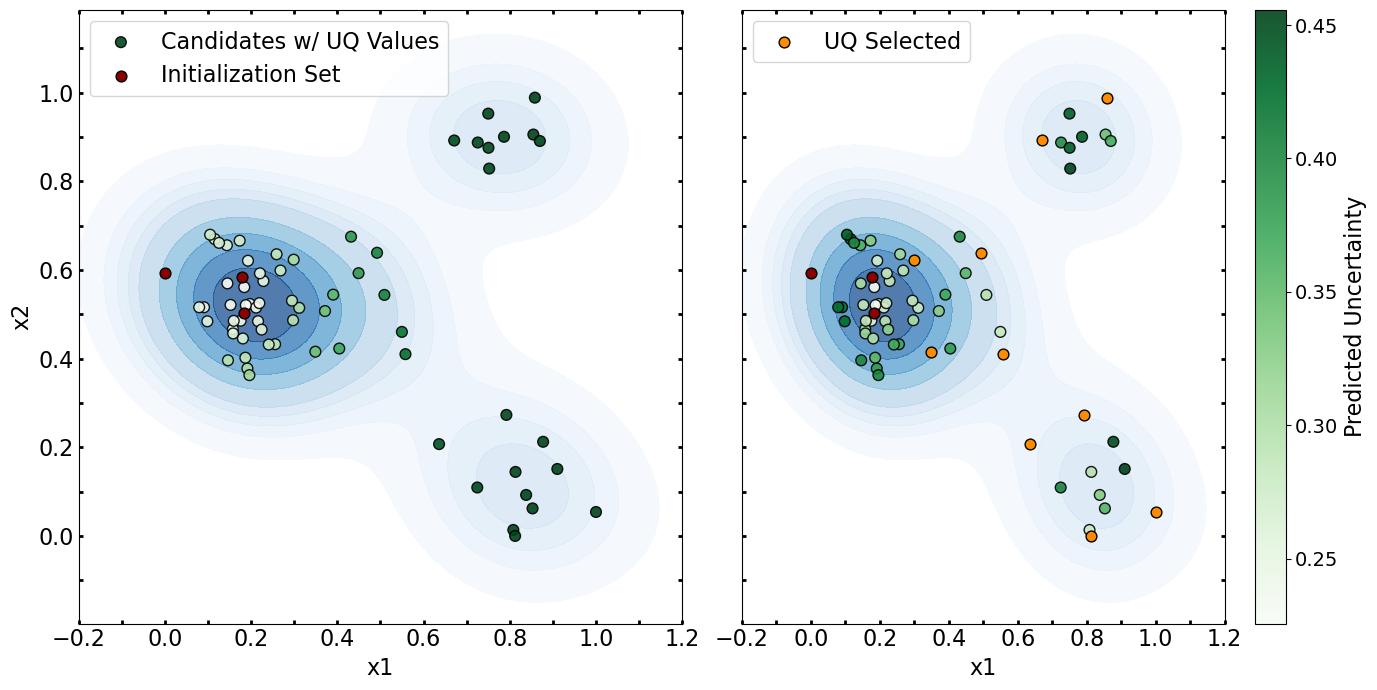

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True, alpha=0.7)
cb = ax[0].scatter(uncr_candidates[0][:,0], uncr_candidates[0][:,1], c=uncr_pred_candidates[0], cmap="Greens",s=60, edgecolor='k', linewidth=1, label='Candidates w/ UQ Values',alpha=0.9)

ax[0].scatter(xinit_uncr[:3,0], xinit_uncr[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1, label='Initialization Set')
# ax[0].set_title("Initial Candidate Space w/ UQ Values", size=16)
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
cb = ax[1].scatter(uncr_candidates[10][:,0], uncr_candidates[10][:,1], c=uncr_pred_candidates[10], cmap="Greens",s=60, edgecolor='k', linewidth=1, alpha=0.9)
cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("Predicted Uncertainty", size=16)
cbar.ax.tick_params(labelsize=14)
ax[1].scatter(xinit_uncr[3:13,0], xinit_uncr[3:13,1], c='darkorange', s=60, edgecolor='k', linewidth=1, label='UQ Selected')
ax[1].scatter(xinit_uncr[:3,0], xinit_uncr[:3,1], c='darkred', s=60, edgecolor='k', linewidth=1)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)
# ax[1].set_title("First 10 Selected UQ Candidates", size=16)

for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=16)
    ax[i].set_ylabel("x2", size=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,size=3,length=3,width=2,labelsize=14)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left',fontsize=16)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True,length=3,width=2,labelsize=16)

plt.tight_layout()
# fig.savefig("figure_5.pdf", bbox_inches="tight")
plt.show()